Detailed analysis of medical insurance dataset and testing and training of the model

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import shap

In [4]:
df = pd.read_csv('medical_insurance.csv')
df.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,diastolic_bp,ldl,hba1c,plan_type,network_tier,deductible,copay,policy_term_years,policy_changes_last_2yrs,provider_quality,risk_score,annual_medical_cost,annual_premium,monthly_premium,claims_count,avg_claim_amount,total_claims_paid,chronic_count,hypertension,diabetes,asthma,copd,cardiovascular_disease,cancer_history,kidney_disease,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,27.4,Never,NaN,2,0,0,4,121.0,76.0,123.8,5.28,PPO,Bronze,1000,20,4,0,3.73,0.5714,6938.06,876.05,73.00,1,4672.59,4672.59,1,0,0,0,0,0,0,0,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,1,26.6,Never,Weekly,2,0,0,3,131.0,79.0,97.3,4.82,POS,Gold,1000,10,1,0,3.10,1.0000,1632.61,445.10,37.09,4,297.27,1189.08,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,3,31.5,Never,NaN,1,0,0,4,160.0,84.0,129.5,5.51,HMO,Platinum,500,20,10,0,3.90,1.0000,7661.01,1538.02,128.17,0,0.00,0.00,3,1,0,0,0,0,1,0,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,31.6,Never,NaN,0,0,0,1,104.0,68.0,160.3,8.50,HMO,Silver,500,20,5,0,3.89,0.2857,5130.27,820.63,68.39,0,0.00,0.00,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,30.5,Never,Daily,3,0,0,2,136.0,83.0,171.0,5.20,POS,Platinum,500,10,7,0,3.90,0.8681,1700.73,500.93,41.74,1,1002.24,1002.24,2,1,0,0,0,0,0,0,0,1,0,2,0,1,1,0,1,0


In [ ]:
df.shape

(100000, 54)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [7]:
print(df.head())
print(df.describe())

   person_id  age     sex  ... proc_lab_count is_high_risk  had_major_procedure
0      75722   52  Female  ...              1            0                    0
1      80185   79  Female  ...              1            1                    0
2      19865   68    Male  ...              0            1                    0
3      76700   15    Male  ...              0            0                    0
4      92992   53    Male  ...              0            1                    0

[5 rows x 54 columns]
           person_id            age  ...   is_high_risk  had_major_procedure
count  100000.000000  100000.000000  ...  100000.000000        100000.000000
mean    50000.500000      47.521500  ...       0.367810             0.169700
std     28867.657797      15.988752  ...       0.482212             0.375371
min         1.000000       0.000000  ...       0.000000             0.000000
25%     25000.750000      37.000000  ...       0.000000             0.000000
50%     50000.500000      48.000000

In [8]:
df.isna().sum()

person_id                          0
age                                0
sex                                0
region                             0
urban_rural                        0
income                             0
education                          0
marital_status                     0
employment_status                  0
household_size                     0
dependents                         0
bmi                                0
smoker                             0
alcohol_freq                   30083
visits_last_year                   0
hospitalizations_last_3yrs         0
days_hospitalized_last_3yrs        0
medication_count                   0
systolic_bp                        0
diastolic_bp                       0
ldl                                0
hba1c                              0
plan_type                          0
network_tier                       0
deductible                         0
copay                              0
policy_term_years                  0
p

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
df.columns = df.columns.str.strip()

In [11]:
df_filled = df.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
print(df.head())
print(df.describe())

   person_id  age     sex  ... proc_lab_count is_high_risk  had_major_procedure
0      75722   52  Female  ...              1            0                    0
1      80185   79  Female  ...              1            1                    0
2      19865   68    Male  ...              0            1                    0
3      76700   15    Male  ...              0            0                    0
4      92992   53    Male  ...              0            1                    0

[5 rows x 54 columns]
           person_id            age  ...   is_high_risk  had_major_procedure
count  100000.000000  100000.000000  ...  100000.000000        100000.000000
mean    50000.500000      47.521500  ...       0.367810             0.169700
std     28867.657797      15.988752  ...       0.482212             0.375371
min         1.000000       0.000000  ...       0.000000             0.000000
25%     25000.750000      37.000000  ...       0.000000             0.000000
50%     50000.500000      48.000000

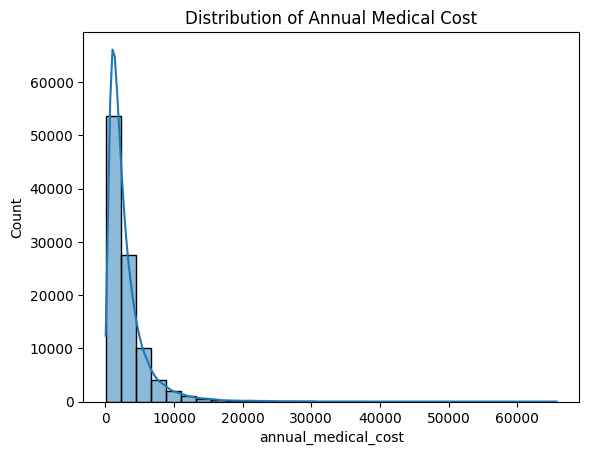

In [13]:
sns.histplot(df['annual_medical_cost'], bins=30, kde=True)
plt.title('Distribution of Annual Medical Cost')
plt.savefig('annual_medical_cost_distribution.png')
plt.show()

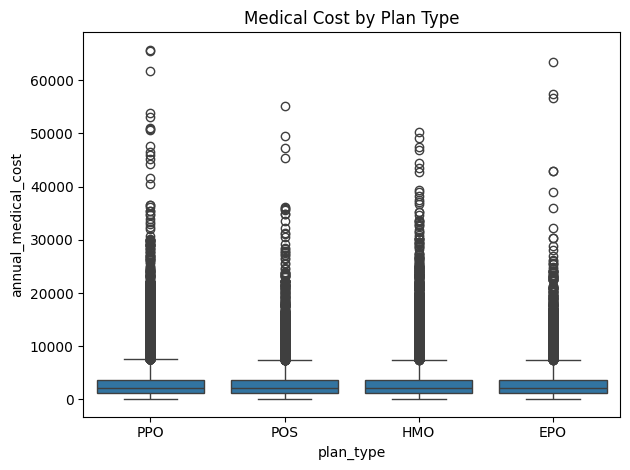

In [14]:
sns.boxplot(x=df['plan_type'], y=df['annual_medical_cost'])
plt.title('Medical Cost by Plan Type')
plt.savefig('medical_cost_by_plan_type.png')
plt.tight_layout()
plt.show()

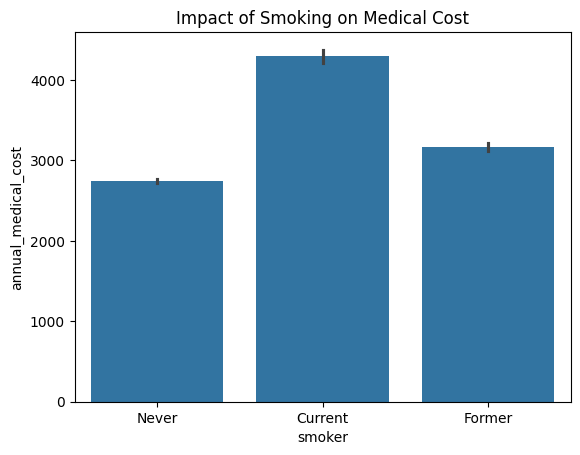

In [15]:
sns.barplot(x='smoker', y='annual_medical_cost', data=df)
plt.title('Impact of Smoking on Medical Cost')
plt.savefig('impact_of_smoking_on_medical_cost.png')
plt.show()

In [16]:
px.scatter(df, x="bmi", y="annual_medical_cost", color="smoker", title="BMI vs Cost by Smoking Status").show()

In [18]:
df_clean = df.select_dtypes(exclude=['object']).copy()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df[col].astype(str))
X = df_clean.drop(['annual_medical_cost', 'person_id'], axis=1)
y = df_clean['annual_medical_cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mae = mean_absolute_error(y_test,y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"MAE: {mae:.2f}, RMSE: {mse:.2f}")

MAE: 7.53, RMSE: 15660.81


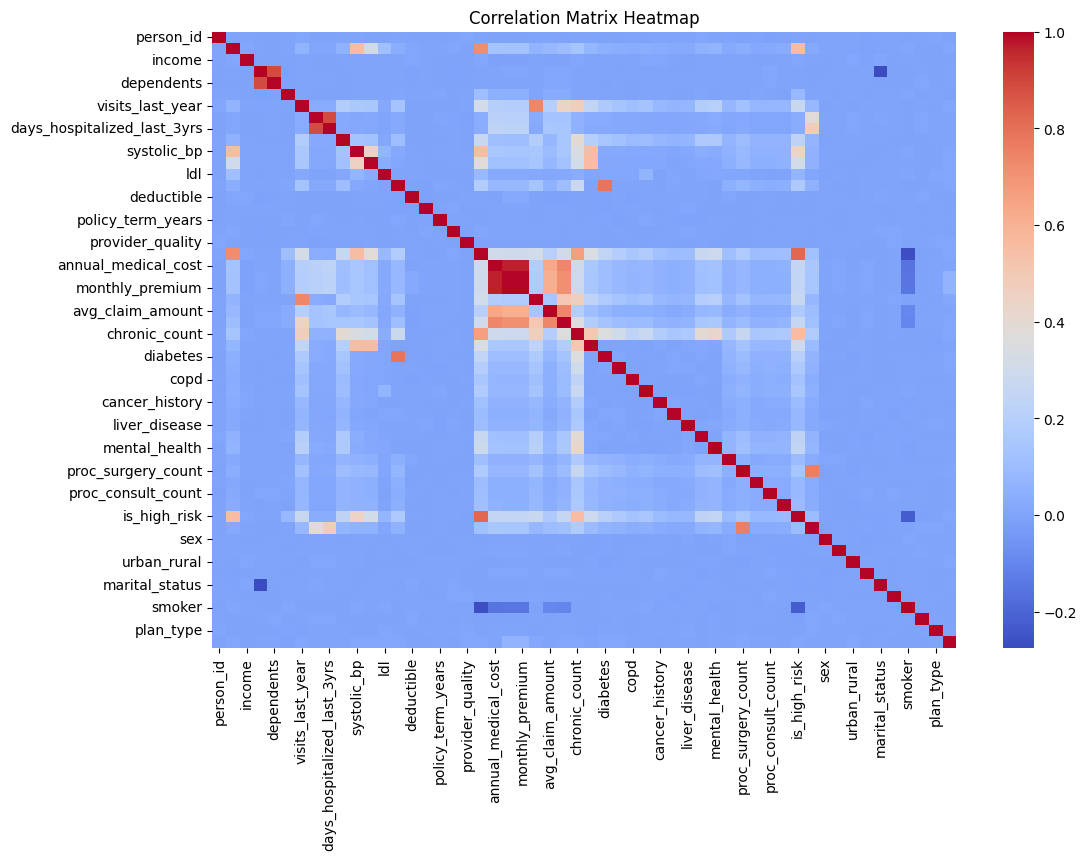

In [19]:
corr = df_clean.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix Heatmap")
plt.savefig('Correlation Matrix Heatmap.png')
plt.show()

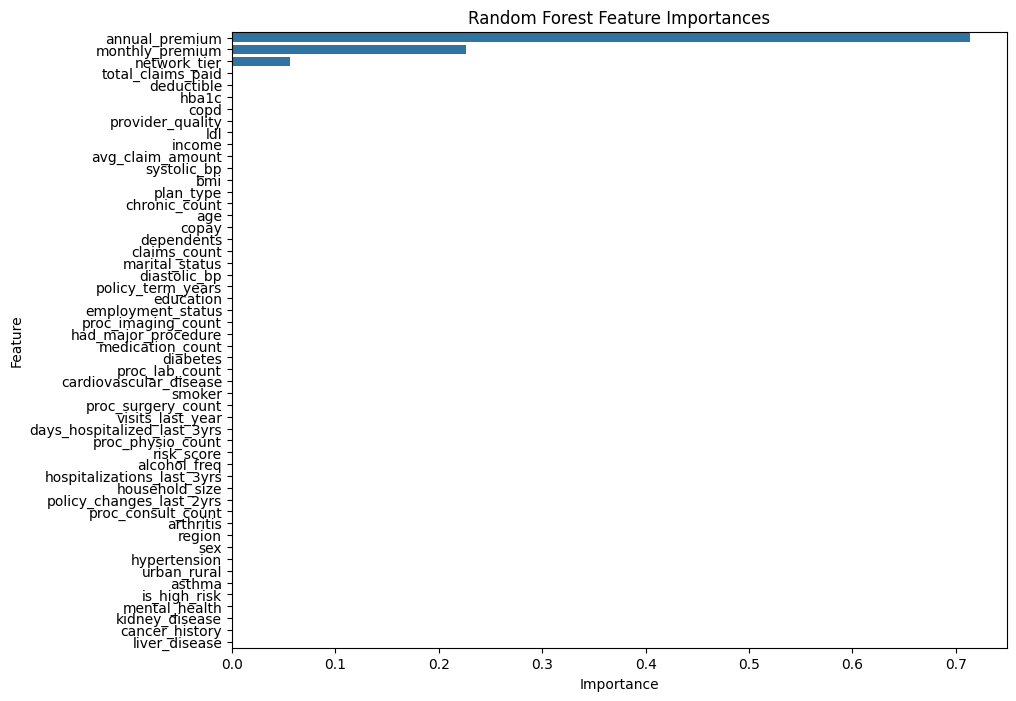

In [21]:
importances = rf.feature_importances_
features = X.columns
feat_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df)
plt.title('Random Forest Feature Importances')
plt.savefig('Random Forest Feature Importances.png')
plt.show()

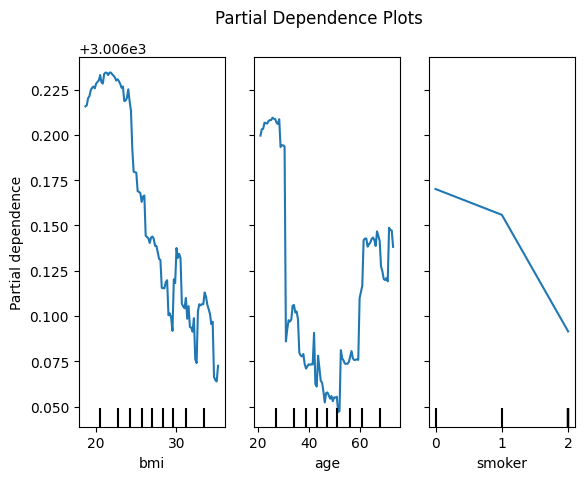

In [22]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(rf, X_test, features=['bmi', 'age', 'smoker'], kind="average")
plt.suptitle('Partial Dependence Plots')
plt.savefig('Partial Dependence Plots.png')
plt.show()

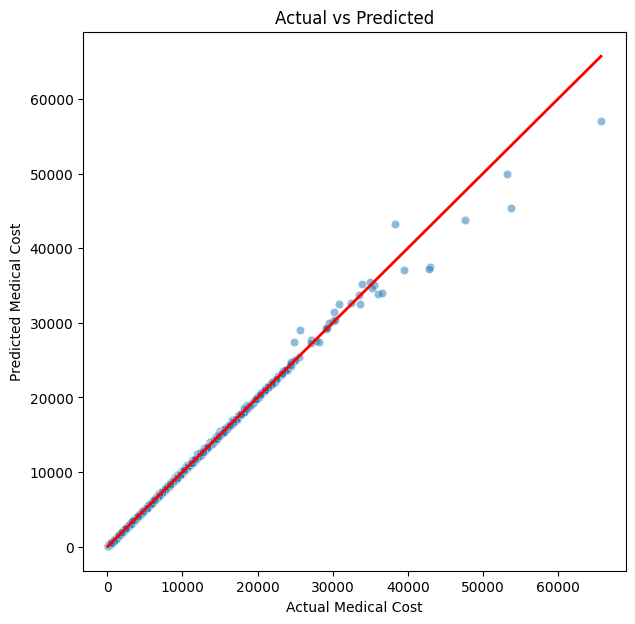

In [24]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel('Actual Medical Cost')
plt.ylabel('Predicted Medical Cost')
plt.title('Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)
plt.savefig('Actual vs Predicted.png')
plt.show()

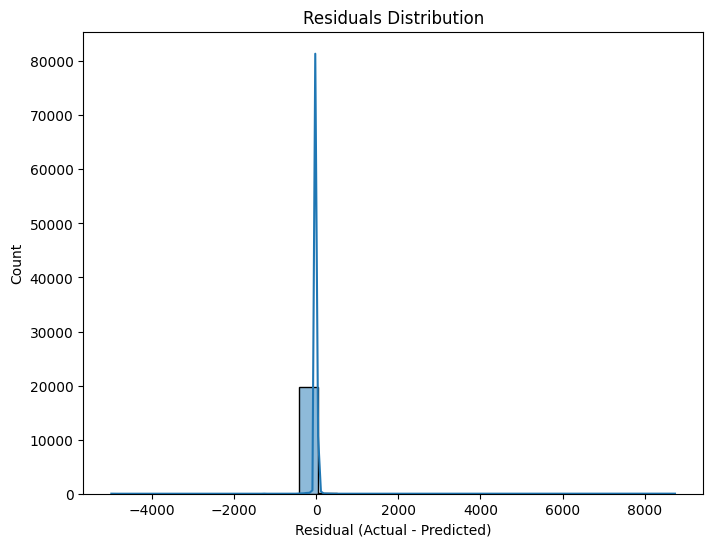

In [25]:
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residual (Actual - Predicted)')
plt.savefig('Residual Distribution.png')
plt.show()

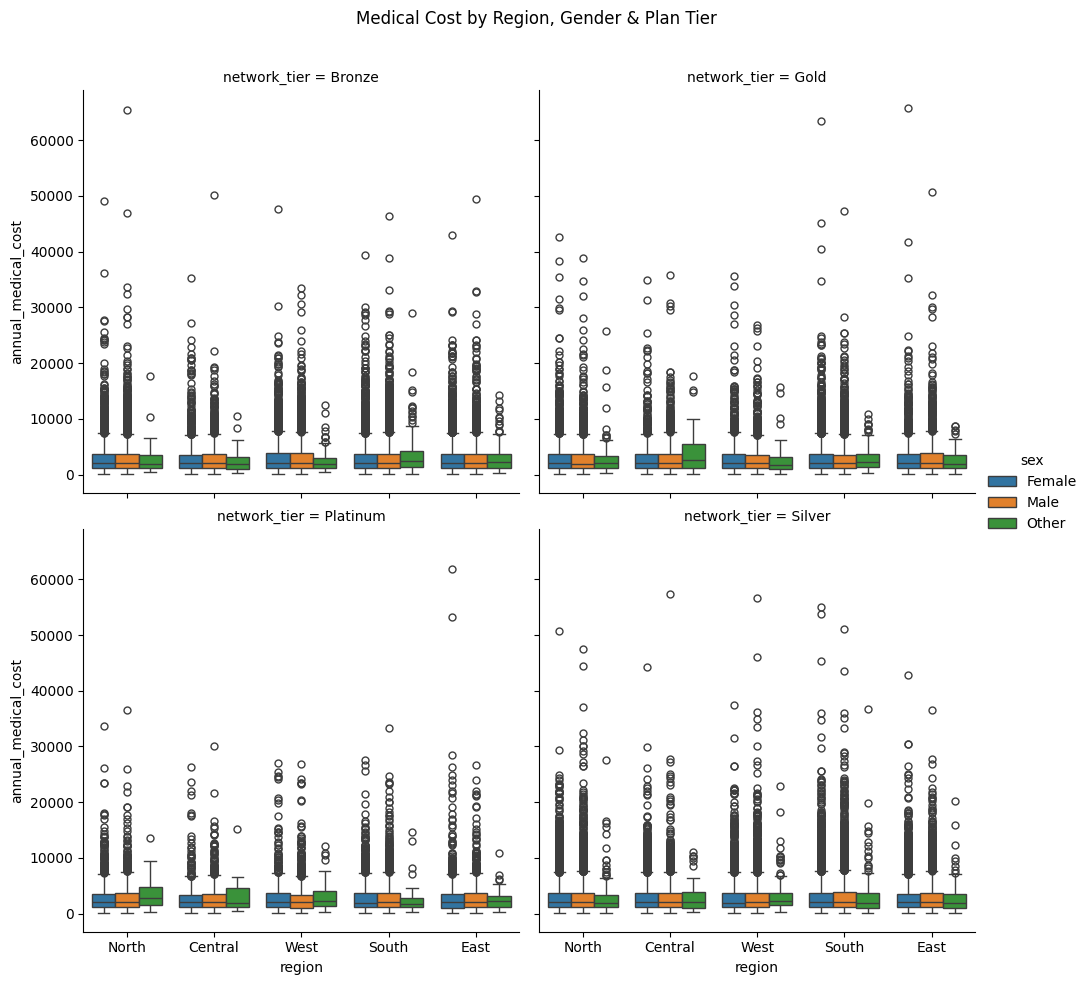

In [27]:
sns.catplot(x="region",y="annual_medical_cost", hue="sex", col="network_tier", data=df, kind="box", col_wrap=2, height=5)
plt.subplots_adjust(top=0.9)
plt.suptitle('Medical Cost by Region, Gender & Plan Tier')
plt.savefig('Medical Cost by Region, Gender & Plan Tier.png')
plt.show()

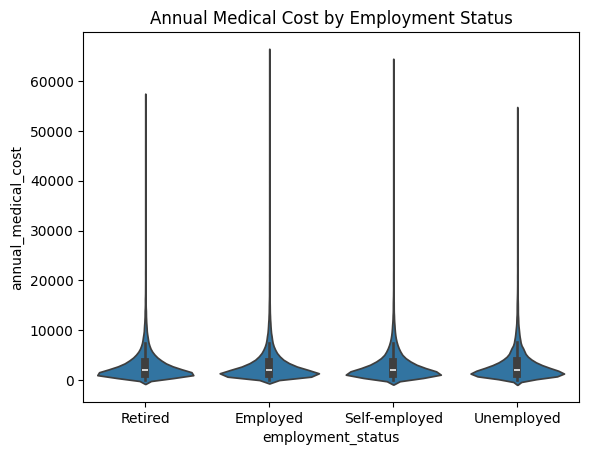

In [28]:
sns.violinplot(x="employment_status", y="annual_medical_cost", data=df)
plt.title("Annual Medical Cost by Employment Status")
plt.savefig("Annual Medical Cost by Employment Status.png")
plt.show()

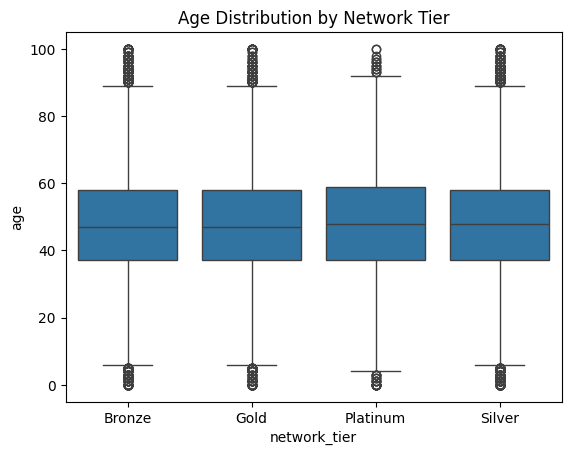

In [30]:
sns.boxplot(x="network_tier", y="age", data=df)
plt.title("Age Distribution by Network Tier")
plt.savefig("Age Distribution by Network Tier")
plt.show()

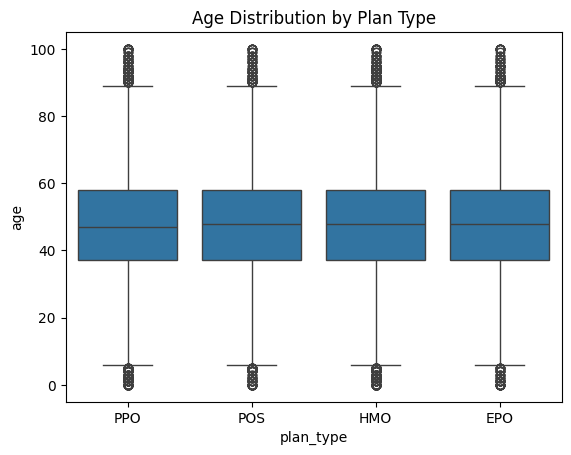

In [31]:
sns.boxplot(x="plan_type", y="age", data=df)
plt.title("Age Distribution by Plan Type")
plt.savefig("Age Distribution by Plan Type")
plt.show()

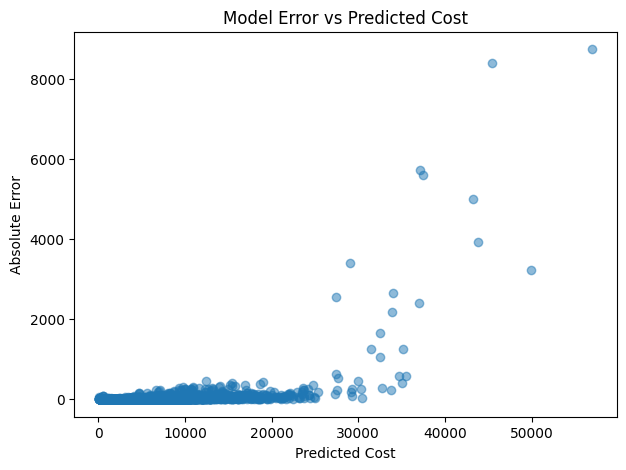

In [32]:
error = abs(y_test - y_pred)
plt.figure(figsize=(7,5))
plt.scatter(y_pred, error, alpha=0.5)
plt.xlabel('Predicted Cost')
plt.ylabel('Absolute Error')
plt.title('Model Error vs Predicted Cost')
plt.savefig('Model Error vs Predicted Cost.png')
plt.show()